# Deep Learning on the MNIST Digit Recognition Problem.

The digit recognition problem is a classic problem in deep learning/neural networks that has been around for several decades. We use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) in this tutorial and then use a simple neural network to perform classification on the images.

**Problem Statement**: Given a picture of a handwritten digit, classify the number within the image.

This notebook file will walk you through the code, with more text boxes explaining what is going on. To run the code, there are several ways. First, you can select each block of code and press ``Ctrl + Enter``. You can also click on Runtime in the top menu for more options; you can also reset everything and rerun.

## Pytorch
Pytorch is a very essential library to learn if you want to get into AI development. It allows you to perform operations on data; you will need a background on linear algebra and signal processing to fully understand everything, but don't worry. Pytorch also lets you create your own models by defining it in a [class](https://www.geeksforgeeks.org/python-classes-and-objects/), which you can then train under many settings, some of which you will see.

I recommend you read through the linked article on classes in a coding context and go over more if you are still unsure. You may want to look up "object oriented programming."

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
import matplotlib.pyplot as plt # this is a plotting library; very popular
import time # use for timing how long it takes to train

## Load the Data
In this step, we load the dataset. Data can take on many forms: .csv files (tabular data), images, audio, video, etc. In the case of MNIST, these are images, which is a collection of tens of thousands of images. Each image is 28 pixels by 28 pixels.

The code block below just loads the images and specifies the number of images for training the model and for testing the model. When we test the model, we test it using images that the model has never seen before. This process of testing or evaluation gives us an idea as to how the model performs.

In [3]:
# Get dataset from directory
dataset = MNIST(root='data', download=True, train=True, transform=transforms.ToTensor())
test_size = 5000
train_size = len(dataset) - test_size

In [4]:
# Create subset datasets for training and testing
train_subds, test_subds = random_split(
    dataset=dataset,
    lengths=[train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

## Data Loader
A data loader is an object that basically lets us easily access data samples (which is the main important thing to remember for now). It is an instance of the DataLoader class.

In many cases, we have to code our own dataset processing since each dataset is different.

In [5]:
# Get DataLoader objects (without worrying about device yet)
batch_size = 128
n_epochs = 10

train_loader = DataLoader(
    dataset=train_subds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    dataset=test_subds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

## Visualize the Data
We've been talking about the data, but now let's visualize several samples below.

In [6]:
def show_all_batch_imgs8x8(dl=None):
    ''' Show 8x8 grid of images from DataLoader object

    :param dl: DataLoader object
    :return: NA
    '''
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break

    plt.show()

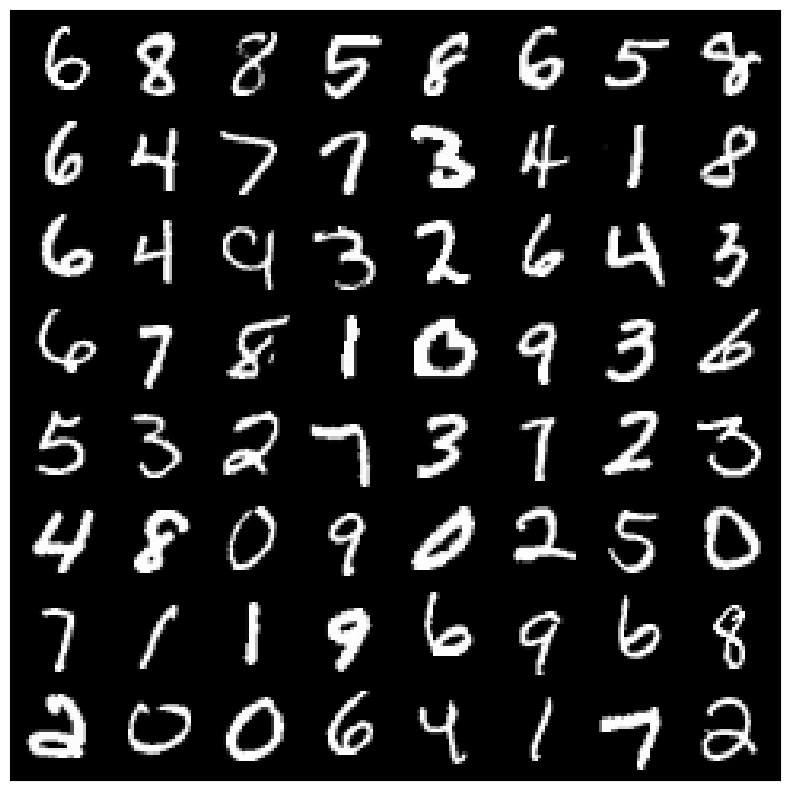

In [7]:
show_all_batch_imgs8x8(dl=train_loader)

## The Deep Learning Model
It is important to remember that we must explore the data--to understand it as best we can before we apply a solution to it! Once we do this, we can then create a solution to this image classification problem.

With the above comments in mind, some guys a long time ago decided to apply neural networks to i) learn distinctive features of the numbers, and then ii) decode those features to classify what is in the image. You will find below the definition of the Multilayer Perceptron (MLP) model. This is a really simple model by modern standards. The MLP model is just a series of matrix multiplications between the input and weights. The weights are adjusted and this is the part that learns to classify numbers, put simply, through a process called backpropagation (this involves quite a bit of calculus knowledge, mainly partial derivatives and the chain rule). These weight matrices you can think of as contained within the ``nn.Linear`` layer, which are treated as functions (see the ``forward`` function).

The inputs ``n_features`` and ``n_outputs`` just mean how many values to process, hence 28*28=784 and outputs being set to 10. Being familiar with linear algebra makes this easier to get an intuition of.

### What is a device?
After initializing the ``mnist_model`` variable, we need to set the device. The device in this context is just the graphics processing unit or GPU. A GPU allows us to perform computations in _parallel_, and this massively speeds up the training process. Initially, everything is loaded onto host (or CPU) memory, but we need to load it on GPU memory. Pytorch allows us to do this easily. I have some functions to handle this.

Be warned that on Google Colab, however, GPU access may not be guaranteed.

In [8]:
class MLP(nn.Module):
    ''' Simple Multilayer Perceptron/Neural Network'''
    def __init__(self, n_features=None, n_outputs=None):
        ''' Constructor

        :param n_features: (int) number of input features for first layer
        :param n_outputs: (int) number of outputs for last layer
        '''
        super().__init__()

        self.linear1 = nn.Linear(in_features=n_features, out_features=16)
        self.linear2 = nn.Linear(in_features=16, out_features=16)
        self.out1 = nn.Linear(in_features=16, out_features=n_outputs)

    def forward(self, x=None):
        ''' Forward propagation to get prediction

        :param x: tensor for data
        :return: model prediction
        '''
        out = x.view(x.size(0), -1)
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.out1(out)

        return out

In [9]:
# Get MLP model
mnist_model = MLP(n_features=28*28, n_outputs=10)

In [10]:
def get_default_device():
    ''' Check if GPU is available

    :return: NA
    '''
    if torch.cuda.is_available():
        print('GPU available.')
        return torch.device('cuda')
    else:
        print('Using CPU.')
        return torch.device('cpu')


def move_to_device(data=None, device=None):
    ''' Move individual tensor to chosen device
    (since we cannot do this for the DataLoader object itself,
    we must move the input data itself to the device)

    :param data: dataset as Tensor
    :param device: device (i.e., whether CUDA is available)
    :return: Data migrated to device
    '''
    if isinstance(data, (list, tuple)):
        return [move_to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        ''' Wrap DataLoader object to move data to designated device'''
        self.dl = dl
        self.device = device

    def __iter__(self):
        ''' Yield batch of data after moving it to device'''
        for b in self.dl:  # iterate over samples in batch
            yield move_to_device(b, self.device)  # return next item, which is in appropriate device

    def __len__(self):
        ''' Number of batches'''
        return len(self.dl)

In [11]:
# Switch to device, and move model and data to device
# You should see "GPU available" but using a CPU in this case is ok since the model is tiny.

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
mnist_model = move_to_device(mnist_model, device)

Using CPU.


## Train
Now we train the model. This process involves, as we've discussed before, a good amount several courses' worth of calculus, linear algebra, and probability. Essentially, the steps to train are below.

**Training Steps:**
1. Load sample
2. Get output of model on the sample
3. Compute the loss between the prediction and groud truth (real answer)
4. Perform backpropagation
5. Repeat for all samples in the training set

**Evaluation/Testing Steps:**
1. Load sample
2. Get output of model on the sample
3. Compute the loss between the prediction and groud truth (real answer)
4. Compute metric (e.g., accuracy for classification)
5. Repeat for all samples in the test set

What is neat about Pytorch is that it keeps track of computations "under the hood" and then performs the backpropagation, without you having to code it, which is very tedious.

In [12]:
def avg_list_tensors(tensor_list: list):
    ''' Compute mean of list of (single-value) tensors

    :param tensor_list: list of tensors
    :return: mean of values of each tensor
    '''
    return torch.stack(tensor_list).mean().item()

In [13]:
def compute_batch_loss(model=None, batch=None):
    ''' Compute loss on batch of data

    :param model: torch.nn.Module model
    :param batch: batch of tensors
    :return: loss
    '''
    inputs, labels = batch
    out = model(inputs)  # get predictions
    loss = F.cross_entropy(input=out, target=labels)  # compute loss
    return loss

In [14]:
def get_accuracy(out=None, actual=None):
    ''' Get accuracy

    :param out: model predictions of shape (batch_size,)
    :param actual: labels in a tensor of shape (batch size,)
    :return:
    '''
    _, preds = torch.max(out, dim=1)
    acc = torch.tensor(torch.sum(preds==actual).item() / len(preds))
    return acc

In [15]:
@torch.no_grad()
def evaluate(model=None, val_loader=None):
    ''' Without modifying gradients, evaluate validation set of images to get average loss and accuracy (over all batches in DataLoader)

    :param model: torch.nn.Module model
    :param val_loader: validation data loader (type DataLoader)
    :return: averaged validation accuracies and averaged validation losses in a dictionary in the form
        {
            'val_acc': number
            'val_loss': number
        }
    '''
    model.eval() # set to evaluate mode, i.e., layers like batch norm and dropout will work
    val_losses = []
    val_accs = []
    val_scores = {}

    for batch in val_loader:
        val_loss = compute_batch_loss(model=model, batch=batch)
        inputs, labels = batch
        out = model(inputs)
        val_accuracy = get_accuracy(out, labels)  # compute accuracy

        val_losses.append(val_loss)
        val_accs.append(val_accuracy)

    val_scores['val_loss'] = avg_list_tensors(val_losses)
    val_scores['val_acc'] = avg_list_tensors(val_accs)

    return val_scores

In [16]:
def train_model(model=None, epochs=10, lr=0.01, train_loader=None, val_loader=None, opt_func=torch.optim.SGD):
    ''' Train basic model

    :param model: model object that inherits from torch.nn.Module
    :param epochs: number of epochs to train for
    :param lr: learning rate
    :param train_loader: training DataLoader object
    :param val_loader: validation DataLoader object
    :param opt_func: optimization function (from torch.optim)
    :return: list of dictionaries, each element having the form for index/epoch i
        {
            'train_loss': number
            'val_acc': number
            'val_loss': number
        }
    '''
    history = []
    optimizer = opt_func(model.parameters(), lr=lr)
    start = time.time()

    for epoch in range(epochs):
        # Train
        model.train() # set to train mode
        train_losses = []

        for batch in train_loader:
            loss = compute_batch_loss(model=model, batch=batch)
            train_losses.append(loss) # add loss of current batch
            loss.backward() # backpropagate on loss
            optimizer.step() # perform single optimization step
            optimizer.zero_grad() # reset gradients to zero for future backpropagation (useful for RNNs, but not here)

        # Evaluate model after training for one additional epoch
        avg_train_loss = avg_list_tensors(train_losses)
        val_scores = evaluate(model=model, val_loader=val_loader) # get validation accuracy and loss

        # Finally, add losses and validation accuracy of current epoch to history list
        epoch_scores = {
            'train_loss': avg_train_loss,
            'val_acc': val_scores['val_acc'],
            'val_loss': val_scores['val_loss']
        }

        history.append(epoch_scores)
        print('Epoch {}/{}: Train loss={:.4f}, Val loss = {:.4f}, Val accuracy = {:.4f}'.format(
            epoch+1,
            epochs,
            avg_train_loss,
            val_scores['val_loss'],
            val_scores['val_acc']
        ))

    end = time.time() - start
    print('Total time: {:.3f} min'.format(end/60))

    return history

As the model trains, you expect "Val accuracy" to go up from a low number to close to ``1.00``. There are many settings to the model you can change. This includes what we call "hyperparameters," model architecture, etc. The loss you can think of as the error, and as the model properly learns, you expect this quantity to go down.

In [17]:
# Train MLP model
history = train_model(
    model=mnist_model,
    epochs=n_epochs,
    lr=0.01,
    train_loader=train_loader,
    val_loader=test_loader,
    opt_func=torch.optim.SGD
)

Epoch 1/10: Train loss=1.9708, Val loss = 1.4187, Val accuracy = 0.6658
Epoch 2/10: Train loss=0.9809, Val loss = 0.7394, Val accuracy = 0.7867
Epoch 3/10: Train loss=0.6215, Val loss = 0.5660, Val accuracy = 0.8359
Epoch 4/10: Train loss=0.4973, Val loss = 0.4670, Val accuracy = 0.8693
Epoch 5/10: Train loss=0.4343, Val loss = 0.4255, Val accuracy = 0.8766
Epoch 6/10: Train loss=0.4002, Val loss = 0.4096, Val accuracy = 0.8832
Epoch 7/10: Train loss=0.3793, Val loss = 0.3893, Val accuracy = 0.8854
Epoch 8/10: Train loss=0.3648, Val loss = 0.3732, Val accuracy = 0.8906
Epoch 9/10: Train loss=0.3536, Val loss = 0.3702, Val accuracy = 0.8900
Epoch 10/10: Train loss=0.3446, Val loss = 0.3555, Val accuracy = 0.8988
Total time: 1.434 min


## Visualize the training history
Now we can

In [18]:
def plot_accuracy(history=None):
    ''' Plot epochs vs accuracy

    :param history: list of dictionaries for losses and validation accuracy per epoch,
        each element having the form for index/epoch i
        {
            'train_loss': number
            'val_acc': number
            'val_loss': number
        }
    :return: NA
    '''
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(val_accuracies, '-rs', label='validation\naccuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [0.0, 1.0]')
    plt.ylim(0.000, 1.000)
    plt.legend(loc='best')
    plt.show()

In [19]:
def plot_losses(history=None):
    ''' Plot epochs vs training loss and validation loss

    :param history: list of dictionaries for losses and validation accuracy per epoch,
        each element having the form for index/epoch i
        {
            'train_loss': number
            'val_acc': number
            'val_loss': number
        }
    :return: NA
    '''
    train_losses  = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bs', label='training\nloss')
    plt.plot(val_losses, '-rs', label='validation\nloss')
    plt.title('Training and Validation Losses vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0.0)
    plt.legend(loc='best')
    plt.show()

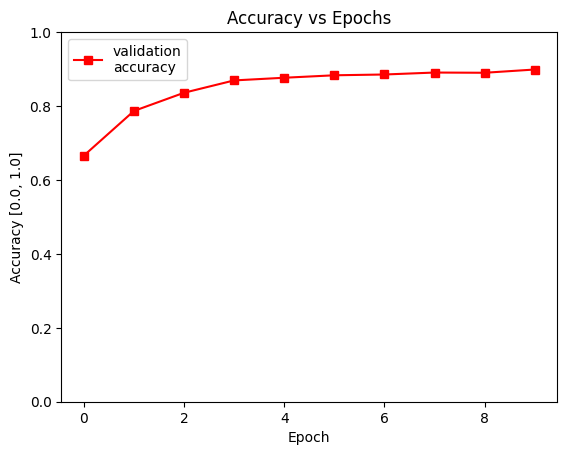

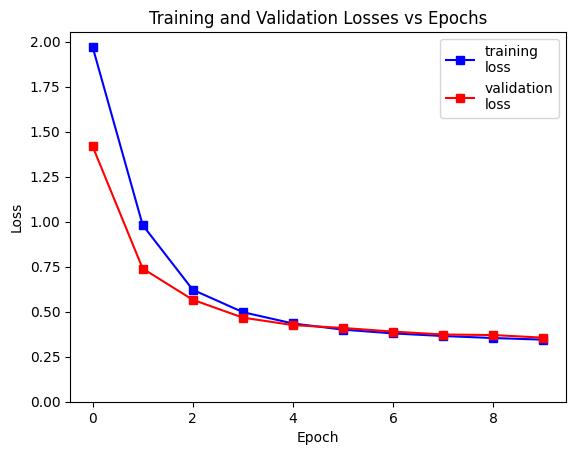

In [20]:
# Visualize loss and accuracy history
plot_accuracy(history)
plot_losses(history)

## Visualize Predictions
Now we can test the model and visualize the image. We can check how the model performs on new images that the model has never seen before!

In [21]:
# Evaluate final model
scores = evaluate(model=mnist_model, val_loader=test_loader)
print('Test scores: ', scores)

Test scores:  {'val_loss': 0.35885006189346313, 'val_acc': 0.8929687738418579}


In [22]:
# Predict on a few inputs
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

In [23]:
def predict(x=None, model=None):
    ''' Use model to make prediction on input

    :param x: batch of images in tensor
    :param model: model object that inherits from torch.nn.Module
    :return: prediction label
    '''
    device = get_default_device()
    x = move_to_device(data=x, device=device)
    predict_vector = model(x)
    best_pred_values, best_pred_indices = torch.max(predict_vector, dim=1)

    return best_pred_indices[0].item()

In [24]:
x, label = dataset[0]
x = x.unsqueeze(0)
pred = predict(x=x, model=mnist_model)
print('True label: {}, Predicted: {}'.format(label, pred))

Using CPU.
True label: 5, Predicted: 3


Using CPU.
True label: 3, Predicted: 3


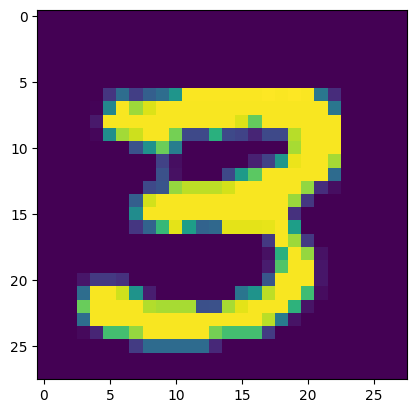

In [25]:
x, label = dataset[111]
x = x.unsqueeze(0)
pred = predict(x=x, model=mnist_model)
print('True label: {}, Predicted: {}'.format(label, pred))
plt.imshow(x[0][0])

Using CPU.
True label: 4, Predicted: 4


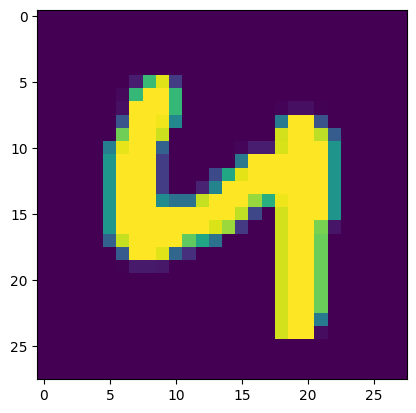

In [26]:
x, label = dataset[222]
x = x.unsqueeze(0)
pred = predict(x=x, model=mnist_model)
print('True label: {}, Predicted: {}'.format(label, pred))
plt.imshow(x[0][0])

Using CPU.
True label: 8, Predicted: 8


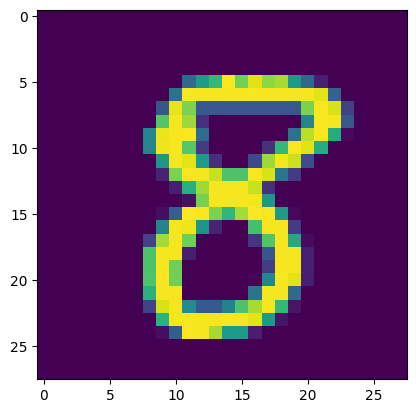

In [27]:
x, label = dataset[333]
x = x.unsqueeze(0)
pred = predict(x=x, model=mnist_model)
print('True label: {}, Predicted: {}'.format(label, pred))
plt.imshow(x[0][0])

Using CPU.
True label: 2, Predicted: 1


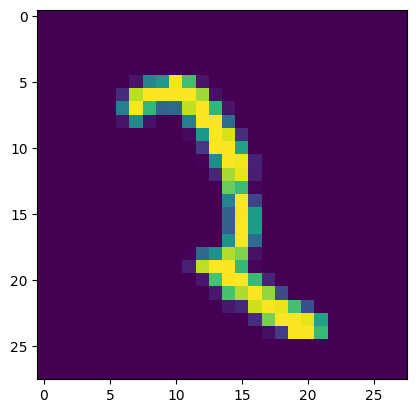

In [28]:
x, label = dataset[444]
x = x.unsqueeze(0)
pred = predict(x=x, model=mnist_model)
print('True label: {}, Predicted: {}'.format(label, pred))
plt.imshow(x[0][0])

Using CPU.
True label: 2, Predicted: 2


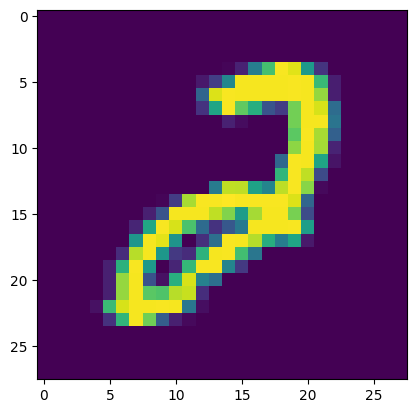

In [29]:
x, label = dataset[555]
x = x.unsqueeze(0)
pred = predict(x=x, model=mnist_model)
print('True label: {}, Predicted: {}'.format(label, pred))
plt.imshow(x[0][0])

## Saving and Loading Trained Models
Pytorch also lets us save the model weights, so we can save our progress and our final trained model. We can then load the weights in another program and evaluate, or even train it further.

In [30]:
# Save model
'''
filename = 'mnist_model.pth'
torch.save(mnist_model.state_dict(), filename)
'''

"\nfilename = 'mnist_model.pth'\ntorch.save(mnist_model.state_dict(), filename)\n"

In [31]:
# Reload model
'''
mnist_model2 = mlp.MLP(n_features=28*28, n_outputs=10)
mnist_model2.load_state_dict(torch.load(filename))
scores = te.evaluate(model=mnist_model, val_loader=test_loader)
print('Model 2 test scores: ', scores)
'''

"\nmnist_model2 = mlp.MLP(n_features=28*28, n_outputs=10)\nmnist_model2.load_state_dict(torch.load(filename))\nscores = te.evaluate(model=mnist_model, val_loader=test_loader)\nprint('Model 2 test scores: ', scores)\n"